In [2]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchinfo import summary

In [3]:
# 이미지 데이터 준비
filename = '../DATA/IMAGE/naeun1.jpg'

In [4]:
# Color 이미지
imgNP = cv2.imread(filename = filename) / 255
imgNP2 = cv2.resize(imgNP, (50, 50))
print(imgNP.shape, imgNP.ndim, '---', imgNP2.shape, imgNP2.shape)

# Gray 이미지
grayNP = cv2.imread(filename = filename, flags = cv2.IMREAD_GRAYSCALE) / 255
grayNP2 = cv2.resize(grayNP, (50, 50))
print(grayNP.shape, grayNP.ndim, '---', grayNP2.shape, grayNP2.ndim)

(625, 500, 3) 3 --- (50, 50, 3) (50, 50, 3)
(625, 500) 2 --- (50, 50) 2


In [5]:
# numpy ==> FloatTensor 변환
colorT = torch.FloatTensor(imgNP2)
grayT = torch.FloatTensor(grayNP2)

In [6]:
print(f'[colorT] shape : {colorT.shape}, ndim : {colorT.ndim}D')
print(f'[grayT] shape : {grayT.shape}, ndim : {grayT.ndim}D')

[colorT] shape : torch.Size([50, 50, 3]), ndim : 3D
[grayT] shape : torch.Size([50, 50]), ndim : 2D


In [7]:
# Pytorch 이미지 데이터 형식 (C, H, W) ==> 
colorT = colorT.permute(2, 1, 0)
grayT.unsqueeze_(dim = 0)

print(f'[colorT] shape : {colorT.shape}, ndim : {colorT.ndim}D')
print(f'[grayT] shape : {grayT.shape}, ndim : {grayT.ndim}D')

[colorT] shape : torch.Size([3, 50, 50]), ndim : 3D
[grayT] shape : torch.Size([1, 50, 50]), ndim : 3D


### CNN Layer 살펴보기

In [15]:
# 이미지 데이터로 Conv2D
# [1] 흑백 이미지
conLayer = nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 3, stride = 1, padding = 0)   # 입력 출력 shape다름
conLayer2 = nn.Conv2d(in_channels = 5, out_channels = 3, kernel_size = 3, stride = 1, padding = 'same')  # 입력 출력 shape 동일
conLayer2

Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [16]:
output = conLayer(grayT)
output2 = conLayer2(output)

print(f'[output] {output.shape}, [output2] {output2.shape}')

[output] torch.Size([5, 48, 48]), [output2] torch.Size([3, 48, 48])


In [17]:
# Polling Layer : Conv 층에서 추출한 특징을 다운샘플링 진행
# 결과 shape : H, W 줄어듬, C는 그대로
pol1 = nn.MaxPool2d(kernel_size = 3)
pol2 = nn.MaxPool2d(kernel_size = 3, stride = 2)

In [18]:
# conv2D + AF => F.relu
relu1 = F.relu(output)
relu2 = F.relu(conLayer2(relu1))
relu1.shape, relu2.shape

(torch.Size([5, 48, 48]), torch.Size([3, 48, 48]))

In [19]:
# 2번째 Conv2D + AF 결과인 피처맵 전달
fm1 = pol1(relu2)
fm1.shape

torch.Size([3, 16, 16])

In [20]:
fm2 = pol2(relu2)
fm2.shape

torch.Size([3, 23, 23])

### 추출된 Feature Map 확인

In [22]:
# 구성 : Conv2D + Conv2D + Pooling
print(f'===> [input] {grayT.shape}')

output1 = conLayer(grayT)
relu1 = F.relu(output1)
print(f'===> [relu1] {relu1.shape}')

output2 = conLayer2(relu1)
relu2 = F.relu(output2)
print(f'===> [relu2] {relu2.shape}')

mp1 = pol1(relu2)
print(f'===> [mp1] {mp1.shape}')

===> [input] torch.Size([1, 50, 50])
===> [relu1] torch.Size([5, 48, 48])
===> [relu2] torch.Size([3, 48, 48])
===> [mp1] torch.Size([3, 16, 16])


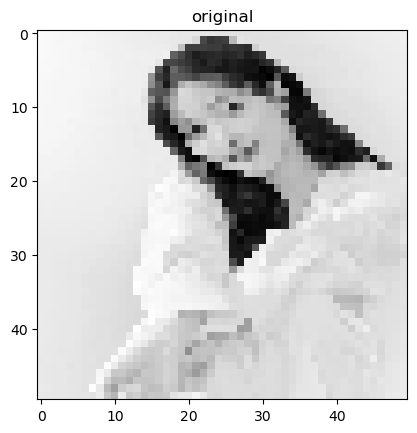

In [24]:
# 시각화
import matplotlib.pyplot as plt

# 입력 그림 3D => 2D
grayImg = grayT.squeeze()
plt.imshow(grayImg, cmap = 'gray')
plt.title('original')
plt.show()

[First Layer]


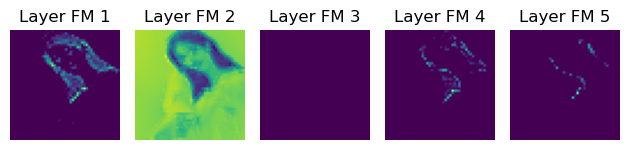

[Second Layer]


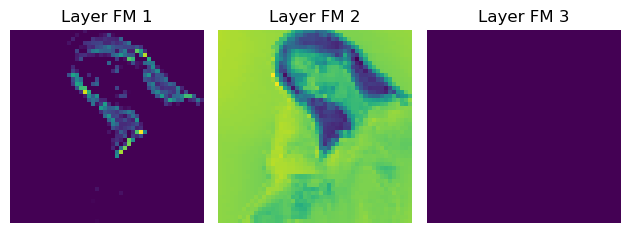

[Final Layer]


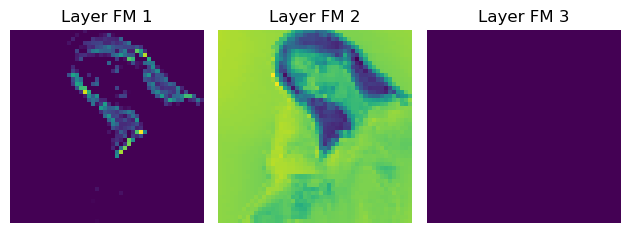

In [33]:
def print_featuremap(fm_tensor, cols, layer_name):
    print(f'[{layer_name} Layer]')
    for idx in range(fm_tensor.shape[0]):
        plt.subplot(1, cols, idx + 1)
        plt.imshow(relu1[idx].detach())
        plt.title(f'Layer FM {idx + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print_featuremap(relu1, 5, 'First')
print_featuremap(relu2, 3, 'Second')
print_featuremap(mp1, 3, 'Final')